# Correlación de tweets y voto en abril de 2019

En este cuaderno intentamos buscar alguna correlación entre la positividad de los tweets sobre los distintos partidos políticos justo con anterioridad a las elecciones de abril de 2019, y el voto de los electores en esos comicios.

El cálculo de la positividad de los tweets ya ha sido calculado en un cuaderno anterior por CCAA, y esa es, lógicamente, la distribución que tendremos en el voto en las elecciones.

Estudiaremos las posibles correlaciones de la positividad de los tweets primero con las diferencia de porcentaje de voto entre PSOE y PP, y a continuación con el porcentaje de voto a Vox.

## Carga y preparación de dataset conjunto de voto y tweets

Comenzamos cargando las librerías necesarias y el dataset de las elecciones de abril de 2019.

In [1]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [2]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

In [3]:
import boto3

BUCKET_NAME = 'electomedia' 

# sustituir por credenciales de acceso. 
s3 = boto3.resource('s3', aws_access_key_id = 'XXXX', 
                          aws_secret_access_key= 'XXXXXXX')

In [4]:
import botocore.exceptions

KEY = 'datos-elecciones-generales-unificados/gen_A19_unif_cols_prov_copia.txt' 

try:
 
  s3.Bucket(BUCKET_NAME).download_file(KEY, 'gen_A19_unif_cols_prov_copia.txt')

except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == "404":
        print("The object does not exist.")
    else:
        raise
    

In [5]:
cols_str = {'cod_ccaa' : 'str', 'cod_prov' : 'str', 'cod_mun' : 'str', 'cod_sec' : 'str', 'cod_grupo' : 'str'}

In [6]:
df_secciones = pd.read_csv('gen_A19_unif_cols_prov_copia.txt', dtype = cols_str)

In [7]:
df_secciones.head()

,Sección,cod_ccaa,cod_prov,cod_mun,cod_sec,CCAA,Provincia,Municipio,Censo_Esc,Votos_Total,Participación,Nulos,Votos_Válidos,Blanco,V_Cand,PP,PSOE,Cs,UP,IU,VOX,UPyD,MP,CiU,ERC,JxC,CUP,DiL,PNV,Bildu,Amaiur,CC,FA,TE,BNG,PRC,GBai,Compromis,PACMA,Otros,% PP,% PSOE,% UP,% Vox,% Cs,% IU,Ganador,Segundo,Tercero,Cuarto,Quinto,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,Hombres,Mujeres,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta persona 2015,Renta hogar 2017,Renta hogar 2015,Renta Salarios 2018,Renta Salarios 2015,Renta Pensiones 2018,Renta Pensiones 2015,Renta Desempleo 2018,Renta Desempleo 2015,dict_res,dict_res_ord,cod_grupo
0,022019041010400101001,01,04,04001,0400101001,Andalucía,Almería,Abla,1014,768,0.757396,5,763,9,754,149,326,131,44,0,88,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,12,2,0.195282,0.427261,0.057667,0.115334,0.171691,0.0,PSOE,PP,Cs,VOX,UP,39,42,47,47,70,72,73,80,89,81,94,87,91,77,72,42,67,56,19,4,0,1249,635,614,0.269816,0.590072,0.140112,291.0,0.243986,0.232986,143.0,0.419580,0.559441,0.329493,9159.0,8788.0,20172.0,19546.0,5574.0,4833.0,3286.0,3082.0,403.0,471.0,"{'PP': 149, 'PSOE': 326, 'Cs': 131, 'UP': 44, 'IU': 0, 'VOX': 88, 'UPyD': 0, 'MP': 0, 'CiU': 0, 'ERC': 0, 'JxC': 0, 'CUP': 0, 'DiL': 0, 'PNV': 0, 'Bildu': 2, 'Amaiur': 0, 'CC': 0, 'FA': 0, 'TE': 0, 'BNG': 0, 'PRC': 0, 'GBai': 0, 'Compromis': 0, 'PACMA': 12, 'Otros': 2}","[('PSOE', 326), ('PP', 149), ('Cs', 131), ('VOX', 88), ('UP', 44), ('PACMA', 12), ('Bildu', 2), ('Otros', 2), ('IU', 0), ('UPyD', 0), ('MP', 0), ('CiU', 0), ('ERC', 0), ('JxC', 0), ('CUP', 0), ('DiL', 0), ('PNV', 0), ('Amaiur', 0), ('CC', 0), ('FA', 0), ('TE', 0), ('BNG', 0), ('PRC', 0), ('GBai', 0), ('Compromis', 0)]",0400101
1,022019041010400201001,01,04,04002,0400201001,Andalucía,Almería,Abrucena,1039,798,0.768046,6,792,7,785,127,380,91,60,0,113,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,7,4,0.160354,0.479798,0.075758,0.142677,0.114899,0.0,PSOE,PP,VOX,Cs,UP,30,30,33,41,71,79,60,75,70,70,108,101,99,86,61,64,61,46,14,2,1,1202,637,565,0.278702,0.609817,0.111481,323.0,0.238390,0.268719,158.0,0.367089,0.601266,0.328482,8827.0,8107.0,17841.0,17115.0,4640.0,4048.0,3418.0,2770.0,568.0,620.0,"{'PP': 127, 'PSOE': 380, 'Cs': 91, 'UP': 60, 'IU': 0, 'VOX': 113, 'UPyD': 0, 'MP': 0, 'CiU': 0, 'ERC': 0, 'JxC': 0, 'CUP': 0, 'DiL': 0, 'PNV': 0, 'Bildu': 3, 'Amaiur': 0, 'CC': 0, 'FA': 0, 'TE': 0, 'BNG': 0, 'PRC': 0, 'GBai': 0, 'Compromis': 0, 'PACMA': 7, 'Otros': 4}","[('PSOE', 380), ('PP', 127), ('VOX', 113), ('Cs', 91), ('UP', 60), ('PACMA', 7), ('Otros', 4), ('Bildu', 3), ('IU', 0), ('UPyD', 0), ('MP', 0), ('CiU', 0), ('ERC', 0), ('JxC', 0), ('CUP', 0), ('DiL', 0), ('PNV', 0), ('Amaiur', 0), ('CC', 0), ('FA', 0), ('TE', 0), ('BNG', 0), ('PRC', 0), ('GBai', 0), ('Compromis', 0)]",0400201
2,022019041010400301001,01,04,04003,0400301001,Andalucía,Almería,Adra,671,519,0.773472,4,515,1,514,162,131,68,44,0,103,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,5,0,0.314563,0.254369,0.085437,0.200000,0.132039,0.0,PP,PSOE,VOX,Cs,UP,36,28,44,40,63,64,54,54,54,61,82,75,67,48,37,40,26,15,3,1,0,892,435,457,0.190583,0.643498,0.165919,7571.0,0.393871,8.487668,3036.0,0.399868,0.459157,0.286226,8965.0,8267.0,26498.0,24688.0,5121.0,4795.0,2499.0,2301.0,337.0,333.0,"{'PP': 162, 'PSOE': 131, 'Cs': 68, 'UP': 44, 'IU': 0, 'VOX': 103, 'UPyD': 0, 'MP': 0, 'CiU': 0, 'ERC': 0, 'JxC': 0, 'CUP': 0, 'DiL': 0, 'PNV': 0, 'Bildu': 1, 'Amaiur': 0, 'CC': 0, 'FA': 0, 'TE': 0, 'BNG': 0, 'PRC': 0, 'GBai': 0, 'Compromis': 0, 'PACMA': 5, 'Otros': 0}","[('PP', 162), ('PSOE', 131), ('VOX', 103), ('Cs', 68), ('UP', 44), ('PACMA', 5), ('Bildu', 1), ('IU', 0), ('UPyD', 0), ('MP', 0), ('CiU', 0), ('ERC', 0), ('JxC', 0), ('CUP', 0), ('DiL', 0), ('PNV', 0), ('Amaiur', 0), ('CC', 0), ('FA', 0), (

In [8]:
df_secciones.CCAA.value_counts()

Andalucía               5981
Cataluña                5071
Galicia                 4417
Castilla - La Mancha    3543
La Rioja                3472
Extremadura             2169
Castilla y León         1948
Murcia                  1711
Aragón                  1450
Canarias                1381
Navarra                 1225
C. Valenciana            965
Asturias                 850
'Islas Baleares'         662
Madrid                   562
Cantabria                467
País Vasco               343
Ceuta                     56
Melilla                   44
Name: CCAA, dtype: int64

In [9]:
df_secciones.columns

Index(['Sección', 'cod_ccaa', 'cod_prov', 'cod_mun', 'cod_sec', 'CCAA',
       'Provincia', 'Municipio', 'Censo_Esc', 'Votos_Total', 'Participación',
       'Nulos', 'Votos_Válidos', 'Blanco', 'V_Cand', 'PP', 'PSOE', 'Cs', 'UP',
       'IU', 'VOX', 'UPyD', 'MP', 'CiU', 'ERC', 'JxC', 'CUP', 'DiL', 'PNV',
       'Bildu', 'Amaiur', 'CC', 'FA', 'TE', 'BNG', 'PRC', 'GBai', 'Compromis',
       'PACMA', 'Otros', '% PP', '% PSOE', '% UP', '% Vox', '% Cs', '% IU',
       'Ganador', 'Segundo', 'Tercero', 'Cuarto', 'Quinto', '0-4', '5-9',
       '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49',
       '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89',
       '90-94', '95-99', '100 y más', 'Población Total', 'Hombres', 'Mujeres',
       '% mayores 65 años', '% 20-64 años', '% menores 19 años',
       'Afiliados SS Minicipio', '% Afiliados SS autónomos',
       '% Afiliados SS / Población', 'Paro Registrado Municipio',
       '% Paro Hombres', '% Paro mayo

Tenemos que calcular el porcentaje de voto por CCAA, por lo que comenzamos a agruparlo. Tenemos que basarnos en los datos absolutos de los votos, descartando el resto de columnas.

In [10]:
columnas_validas= ['Sección','CCAA','Votos_Total','PP', 'PSOE', 'Cs', 'UP', 'VOX']

In [11]:
df=df_secciones[columnas_validas]

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36317 entries, 0 to 36316
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Sección      36317 non-null  object
 1   CCAA         36317 non-null  object
 2   Votos_Total  36317 non-null  int64 
 3   PP           36317 non-null  int64 
 4   PSOE         36317 non-null  int64 
 5   Cs           36317 non-null  int64 
 6   UP           36317 non-null  int64 
 7   VOX          36317 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 2.2+ MB


Hacemos el groupby por comunidades autónomas.

In [13]:
df=df.groupby(['CCAA'], as_index=False).sum()

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19 entries, 0 to 18
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   CCAA         19 non-null     object
 1   Votos_Total  19 non-null     int64 
 2   PP           19 non-null     int64 
 3   PSOE         19 non-null     int64 
 4   Cs           19 non-null     int64 
 5   UP           19 non-null     int64 
 6   VOX          19 non-null     int64 
dtypes: int64(6), object(1)
memory usage: 1.2+ KB


Reformamos los nombres de las CCAA para que coincidan con los presentes en el dataset de la positividad de los tweets.

In [15]:
df['CCAA'] = df['CCAA'].replace({'''Islas Baleares''': 'baleares', 'Andalucía': 'andalucia', 'Aragón': 'aragon', 'Asturias': 'asturias','C. Valenciana': 'comunidadvalenciana','Canarias': 'canarias','Cantabria': 'cantabria','Castilla - La Mancha': 'castillalamancha','Castilla y León': 'castillaleon','Cataluña': 'catalunya','Ceuta': 'ceuta','Extremadura': 'extremadura','Galicia': 'galicia','La Rioja': 'larioja','Madrid': 'madrid','Melilla': 'melilla','Murcia': 'murcia','Navarra': 'navarra','País Vasco': 'euskadi'})
df['CCAA'] = df['CCAA'].replace({'\'Islas Baleares\'': 'baleares'})

In [16]:
df

,CCAA,Votos_Total,PP,PSOE,Cs,UP,VOX
0,baleares,522993,87173,136399,90202,92268,58439
1,andalucia,4630265,785511,1564206,808971,651480,611249
2,aragon,762588,142806,239379,154894,102290,92074
3,asturias,628445,111341,205917,103864,106630,71454
4,comunidadvalenciana,666243,140249,249555,117720,62222,70611
5,canarias,1071879,164500,294931,155303,166470,69384
6,cantabria,361057,77535,90010,54077,36518,39933
7,castillalamancha,1533328,394197,450536,286002,157198,186037
8,castillaleon,1201398,268791,383536,207021,120225,181143
9,catalunya,4148683,200084,958738,477110,613238,148157


Ahora calculamos los porcentajes de voto de los distintos partidos.

In [17]:
df['%PP']=df['PP']/df['Votos_Total']*100
df['%PSOE']=df['PSOE']/df['Votos_Total']*100
df['%Cs']=df['Cs']/df['Votos_Total']*100
df['%UP']=df['UP']/df['Votos_Total']*100
df['%VOX']=df['VOX']/df['Votos_Total']*100

In [18]:
df.head()

,CCAA,Votos_Total,PP,PSOE,Cs,UP,VOX,%PP,%PSOE,%Cs,%UP,%VOX
0,baleares,522993,87173,136399,90202,92268,58439,16.668101,26.080464,17.247267,17.642301,11.173955
1,andalucia,4630265,785511,1564206,808971,651480,611249,16.964709,33.782213,17.471376,14.070037,13.201167
2,aragon,762588,142806,239379,154894,102290,92074,18.726495,31.390344,20.311623,13.413534,12.073885
3,asturias,628445,111341,205917,103864,106630,71454,17.716904,32.766113,16.527142,16.967276,11.369969
4,comunidadvalenciana,666243,140249,249555,117720,62222,70611,21.050728,37.457054,17.669229,9.339235,10.598385


Ya con los porcentajes de votos calculados, los datos absolutos no nos sirven de mucho, así que los eliminamos.

In [19]:
df_porcentaje_voto=df.drop(['Votos_Total','PP', 'PSOE', 'Cs', 'UP', 'VOX'],axis=1)

In [20]:
df_porcentaje_voto


,CCAA,%PP,%PSOE,%Cs,%UP,%VOX
0,baleares,16.668101,26.080464,17.247267,17.642301,11.173955
1,andalucia,16.964709,33.782213,17.471376,14.070037,13.201167
2,aragon,18.726495,31.390344,20.311623,13.413534,12.073885
3,asturias,17.716904,32.766113,16.527142,16.967276,11.369969
4,comunidadvalenciana,21.050728,37.457054,17.669229,9.339235,10.598385
5,canarias,15.346882,27.515326,14.488856,15.530671,6.473119
6,cantabria,21.474449,24.929582,14.977414,10.114192,11.060027
7,castillalamancha,25.708589,29.382885,18.652369,10.252079,12.132890
8,castillaleon,22.373185,31.924142,17.231675,10.007092,15.077684
9,catalunya,4.822832,23.109454,11.500276,14.781510,3.571182


Ahora bien, ha existido una confusión entre los códigos de las CCAA del Ministerio del Interior y los del INE, por lo que tenemos que corrgir la columna de las CCAA en el dataset electoral. Lo arreglamos utilizando un diccionario para hacer el mapeo.

In [21]:
mapeo_ccaa = {
    'andalucia' : 'andalucia',
    'ceuta' : 'ceuta',
    'melilla' : 'melilla',
    'galicia' : 'madrid',
    'asturias' : 'asturias',
    'aragon': 'aragon',
    'canarias' : 'canarias',
    'cantabria' : 'cantabria',
    'madrid' : 'navarra',
    'navarra' : 'murcia',
    'murcia' : 'euskadi',
    'euskadi' : 'larioja',
    'larioja' : 'comunidadvalenciana',
    'comunidadvalenciana' : 'extremadura',
    'extremadura' : 'galicia',
    'castillaleon' : 'castillalamancha',
    'castillalamancha' : 'castillaleon',
    'baleares' : 'baleares',
    'catalunya' : 'catalunya'
}

Y hacemos el mapeo.

In [22]:
df_porcentaje_voto['CCAA'] = df_porcentaje_voto['CCAA'].map(mapeo_ccaa)

In [23]:
df_porcentaje_voto

,CCAA,%PP,%PSOE,%Cs,%UP,%VOX
0,baleares,16.668101,26.080464,17.247267,17.642301,11.173955
1,andalucia,16.964709,33.782213,17.471376,14.070037,13.201167
2,aragon,18.726495,31.390344,20.311623,13.413534,12.073885
3,asturias,17.716904,32.766113,16.527142,16.967276,11.369969
4,extremadura,21.050728,37.457054,17.669229,9.339235,10.598385
5,canarias,15.346882,27.515326,14.488856,15.530671,6.473119
6,cantabria,21.474449,24.929582,14.977414,10.114192,11.060027
7,castillaleon,25.708589,29.382885,18.652369,10.252079,12.132890
8,castillalamancha,22.373185,31.924142,17.231675,10.007092,15.077684
9,catalunya,4.822832,23.109454,11.500276,14.781510,3.571182


Guardamos el dataset de voto por CCAA correcto, y continuamos con nuestro análisis.

In [24]:
# Export dataframe into a CSV
df_porcentaje_voto.to_csv('porcentaje_voto_ccaa.csv', sep=',', index=False)

In [25]:
#para guardar el archivo en s3:

from botocore.exceptions import ClientError

s3_client = boto3.client(
    's3',
    aws_access_key_id='XXXXXXXX',
    aws_secret_access_key='XXXXXXXXXX',    
)

def upload_file(file_name, bucket, object_name=None):
    """Subir un archivo a un bucket
    :param file_name: archivo que hay que subir
    :param bucket: Bucket al que hay que subirlo
    :param object_name: S3 object name. Incluye la carpeta en la que hay que guardarlo. si no hay no se pone nada
    :return: True si sube el archivo, else False
    """

    # If S3 object_name was not specified, use file_name
    if object_name is None:
        object_name = file_name

    # Upload the file
    #s3_client = boto3.client('s3')
    try:
        response = s3_client.upload_file(file_name, bucket, object_name)
    except ClientError as e:
        logging.error(e)
        return False
    return True

In [26]:
upload_file('porcentaje_voto_ccaa.csv',
            'electomedia',
            object_name = "datos-elecciones-generales-unificados/" + 'porcentaje_voto_ccaa.csv'
           )

True

In [27]:
df_porcentaje_voto

,CCAA,%PP,%PSOE,%Cs,%UP,%VOX
0,baleares,16.668101,26.080464,17.247267,17.642301,11.173955
1,andalucia,16.964709,33.782213,17.471376,14.070037,13.201167
2,aragon,18.726495,31.390344,20.311623,13.413534,12.073885
3,asturias,17.716904,32.766113,16.527142,16.967276,11.369969
4,extremadura,21.050728,37.457054,17.669229,9.339235,10.598385
5,canarias,15.346882,27.515326,14.488856,15.530671,6.473119
6,cantabria,21.474449,24.929582,14.977414,10.114192,11.060027
7,castillaleon,25.708589,29.382885,18.652369,10.252079,12.132890
8,castillalamancha,22.373185,31.924142,17.231675,10.007092,15.077684
9,catalunya,4.822832,23.109454,11.500276,14.781510,3.571182


Cargamos el dataset del sentimiento (positividad) de los tweets a los partidos.

In [28]:
import botocore.exceptions

KEY = 'EstimacionOtrasFuentes/df_tweets_def_unique.csv' 

try:
 
  s3.Bucket(BUCKET_NAME).download_file(KEY, 'df_tweets_def_unique.csv')

except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == "404":
        print("The object does not exist.")
    else:
        raise
    

In [29]:
tweets = pd.read_csv('df_tweets_def_unique.csv')

In [30]:
tweets

,Unnamed: 0,CCAA,puntuacion_tweets,tweets_pos_psoe,tweets_pos_UP,tweets_pos_vox,tweets_pos_Cs,tweets_pos_PP,total_tweets_positivos,sum_tweets_sent,%posPP,%posUP,%posPSOE,%posCs,%posVOX
0,0,andalucia,4333.0,521.0,413.0,948.0,181.0,248.0,2311.0,12399,2.000161,3.330914,4.201952,1.459795,7.645778
1,1,aragon,608.0,59.0,71.0,139.0,31.0,20.0,320.0,1783,1.121705,3.982053,3.309030,1.738643,7.795850
2,2,asturias,652.0,79.0,74.0,130.0,19.0,41.0,343.0,1920,2.135417,3.854167,4.114583,0.989583,6.770833
3,3,baleares,913.0,94.0,82.0,179.0,48.0,85.0,488.0,2758,3.081943,2.973169,3.408267,1.740392,6.490210
4,4,canarias,620.0,81.0,72.0,113.0,24.0,36.0,326.0,1861,1.934444,3.868888,4.352499,1.289629,6.072004
5,5,cantabria,240.0,23.0,21.0,54.0,12.0,16.0,126.0,744,2.150538,2.822581,3.091398,1.612903,7.258065
6,6,castillalamancha,716.0,78.0,65.0,133.0,43.0,59.0,378.0,2073,2.846117,3.135552,3.762663,2.074288,6.415822
7,7,castillaleon,1186.0,141.0,104.0,187.0,70.0,105.0,607.0,3284,3.197320,3.166870,4.293544,2.131547,5.694275
8,8,catalunya,4253.0,394.0,394.0,854.0,298.0,309.0,2249.0,11933,2.589458,3.301768,3.301768,2.497276,7.156624
9,9,ceuta,24.0,3.0,2.0,9.0,1.0,1.0,16.0,106,0.943396,1.886792,2.830189,0.943396,8.490566


Como pasaba con las columnas del dataset electoral, nos quedamos con los porcentajes a cada partido.

In [31]:
tweets.columns

Index(['Unnamed: 0', 'CCAA', 'puntuacion_tweets', 'tweets_pos_psoe',
       'tweets_pos_UP', 'tweets_pos_vox', 'tweets_pos_Cs', 'tweets_pos_PP',
       'total_tweets_positivos', 'sum_tweets_sent', '%posPP', '%posUP',
       '%posPSOE', '%posCs', '%posVOX'],
      dtype='object')

In [32]:
cols_tweets = ['CCAA', '%posPP', '%posUP',
       '%posPSOE', '%posCs', '%posVOX']

In [33]:
tweets_simp = tweets[cols_tweets]

In [34]:
tweets_simp

,CCAA,%posPP,%posUP,%posPSOE,%posCs,%posVOX
0,andalucia,2.000161,3.330914,4.201952,1.459795,7.645778
1,aragon,1.121705,3.982053,3.309030,1.738643,7.795850
2,asturias,2.135417,3.854167,4.114583,0.989583,6.770833
3,baleares,3.081943,2.973169,3.408267,1.740392,6.490210
4,canarias,1.934444,3.868888,4.352499,1.289629,6.072004
5,cantabria,2.150538,2.822581,3.091398,1.612903,7.258065
6,castillalamancha,2.846117,3.135552,3.762663,2.074288,6.415822
7,castillaleon,3.197320,3.166870,4.293544,2.131547,5.694275
8,catalunya,2.589458,3.301768,3.301768,2.497276,7.156624
9,ceuta,0.943396,1.886792,2.830189,0.943396,8.490566


Ahora, evidentemente, hacemos un merge de ambos dataset en función de la columna de la CCAA.

In [35]:
votos_tweets = df_porcentaje_voto.merge(tweets_simp, on = 'CCAA', how = 'left')

In [36]:
votos_tweets

,CCAA,%PP,%PSOE,%Cs,%UP,%VOX,%posPP,%posUP,%posPSOE,%posCs,%posVOX
0,baleares,16.668101,26.080464,17.247267,17.642301,11.173955,3.081943,2.973169,3.408267,1.740392,6.490210
1,andalucia,16.964709,33.782213,17.471376,14.070037,13.201167,2.000161,3.330914,4.201952,1.459795,7.645778
2,aragon,18.726495,31.390344,20.311623,13.413534,12.073885,1.121705,3.982053,3.309030,1.738643,7.795850
3,asturias,17.716904,32.766113,16.527142,16.967276,11.369969,2.135417,3.854167,4.114583,0.989583,6.770833
4,extremadura,21.050728,37.457054,17.669229,9.339235,10.598385,2.470265,2.744739,5.489478,1.463861,5.855444
5,canarias,15.346882,27.515326,14.488856,15.530671,6.473119,1.934444,3.868888,4.352499,1.289629,6.072004
6,cantabria,21.474449,24.929582,14.977414,10.114192,11.060027,2.150538,2.822581,3.091398,1.612903,7.258065
7,castillaleon,25.708589,29.382885,18.652369,10.252079,12.132890,3.197320,3.166870,4.293544,2.131547,5.694275
8,castillalamancha,22.373185,31.924142,17.231675,10.007092,15.077684,2.846117,3.135552,3.762663,2.074288,6.415822
9,catalunya,4.822832,23.109454,11.500276,14.781510,3.571182,2.589458,3.301768,3.301768,2.497276,7.156624


## Correlación dif. PSOE-PP y positividad de tweets

Con el dataset completo, ya podemos comenzar a analizar. Lo primero es definir nuestra variable objetivo, que será la diferencia de voto entre PSOE y PP.

In [37]:
votos_tweets['dif_PSOE_PP'] = votos_tweets['%PSOE'] - votos_tweets['%PP']

In [38]:
votos_tweets

,CCAA,%PP,%PSOE,%Cs,%UP,%VOX,%posPP,%posUP,%posPSOE,%posCs,%posVOX,dif_PSOE_PP
0,baleares,16.668101,26.080464,17.247267,17.642301,11.173955,3.081943,2.973169,3.408267,1.740392,6.490210,9.412363
1,andalucia,16.964709,33.782213,17.471376,14.070037,13.201167,2.000161,3.330914,4.201952,1.459795,7.645778,16.817504
2,aragon,18.726495,31.390344,20.311623,13.413534,12.073885,1.121705,3.982053,3.309030,1.738643,7.795850,12.663850
3,asturias,17.716904,32.766113,16.527142,16.967276,11.369969,2.135417,3.854167,4.114583,0.989583,6.770833,15.049209
4,extremadura,21.050728,37.457054,17.669229,9.339235,10.598385,2.470265,2.744739,5.489478,1.463861,5.855444,16.406326
5,canarias,15.346882,27.515326,14.488856,15.530671,6.473119,1.934444,3.868888,4.352499,1.289629,6.072004,12.168444
6,cantabria,21.474449,24.929582,14.977414,10.114192,11.060027,2.150538,2.822581,3.091398,1.612903,7.258065,3.455133
7,castillaleon,25.708589,29.382885,18.652369,10.252079,12.132890,3.197320,3.166870,4.293544,2.131547,5.694275,3.674295
8,castillalamancha,22.373185,31.924142,17.231675,10.007092,15.077684,2.846117,3.135552,3.762663,2.074288,6.415822,9.550956
9,catalunya,4.822832,23.109454,11.500276,14.781510,3.571182,2.589458,3.301768,3.301768,2.497276,7.156624,18.286623


Obviamente, no vamos a utilizar las columnas de porcentaje de voto, sino solo aquellas de la positividad de los tweets a cada partido.

In [39]:
votos_tweets.columns

Index(['CCAA', '%PP', '%PSOE', '%Cs', '%UP', '%VOX', '%posPP', '%posUP',
       '%posPSOE', '%posCs', '%posVOX', 'dif_PSOE_PP'],
      dtype='object')

In [40]:
votos_tweets_model = votos_tweets[[ '%posPP', '%posUP',
       '%posPSOE', '%posCs', '%posVOX', 'dif_PSOE_PP']]

In [41]:
votos_tweets_model

,%posPP,%posUP,%posPSOE,%posCs,%posVOX,dif_PSOE_PP
0,3.081943,2.973169,3.408267,1.740392,6.490210,9.412363
1,2.000161,3.330914,4.201952,1.459795,7.645778,16.817504
2,1.121705,3.982053,3.309030,1.738643,7.795850,12.663850
3,2.135417,3.854167,4.114583,0.989583,6.770833,15.049209
4,2.470265,2.744739,5.489478,1.463861,5.855444,16.406326
5,1.934444,3.868888,4.352499,1.289629,6.072004,12.168444
6,2.150538,2.822581,3.091398,1.612903,7.258065,3.455133
7,3.197320,3.166870,4.293544,2.131547,5.694275,3.674295
8,2.846117,3.135552,3.762663,2.074288,6.415822,9.550956
9,2.589458,3.301768,3.301768,2.497276,7.156624,18.286623


Ya podemos proceder a dividir nuestro dataset en train y test. Como las filas son las CCAA, solo tenemos 19, con lo que el train trandrá unos 14 elementos, y el test 5. Nos quedamos con el train.

In [42]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(votos_tweets_model, test_size=0.25, shuffle=True, random_state=1)

print(f'Dimensiones del dataset de training: {train.shape}')
print(f'Dimensiones del dataset de test: {test.shape}')

# Guardamos
train.to_csv('train_twitter.csv', index=False)
test.to_csv('test_twitter.csv', index=False)

# A partir de este momento cargamos el dataset de train y trabajamos ÚNICAMENTE con él. 

df_train = pd.read_csv('train_twitter.csv')

Dimensiones del dataset de training: (14, 6)
Dimensiones del dataset de test: (5, 6)


In [43]:
df_train

,%posPP,%posUP,%posPSOE,%posCs,%posVOX,dif_PSOE_PP
0,1.459854,4.562044,4.014599,1.094891,6.751825,-3.504685
1,2.470265,2.744739,5.489478,1.463861,5.855444,16.406326
2,2.049780,4.831625,3.074671,0.976086,6.637384,12.362675
3,3.197320,3.166870,4.293544,2.131547,5.694275,3.674295
4,2.000161,3.330914,4.201952,1.459795,7.645778,16.817504
5,2.224504,3.251198,3.678987,1.694045,7.956879,9.094742
6,3.081943,2.973169,3.408267,1.740392,6.490210,9.412363
7,2.690583,2.690583,2.914798,3.363229,3.587444,5.102902
8,3.416624,2.549720,3.671596,1.784804,7.088220,1.301130
9,2.589458,3.301768,3.301768,2.497276,7.156624,18.286623


Ahora calculamos las correlaciones entre columnas. No parece muy esperanzador, ya que ninguna parece correlacinada con la objetivo. Curiosa la correlación entra la positividad de los tweets del PP y Cs.

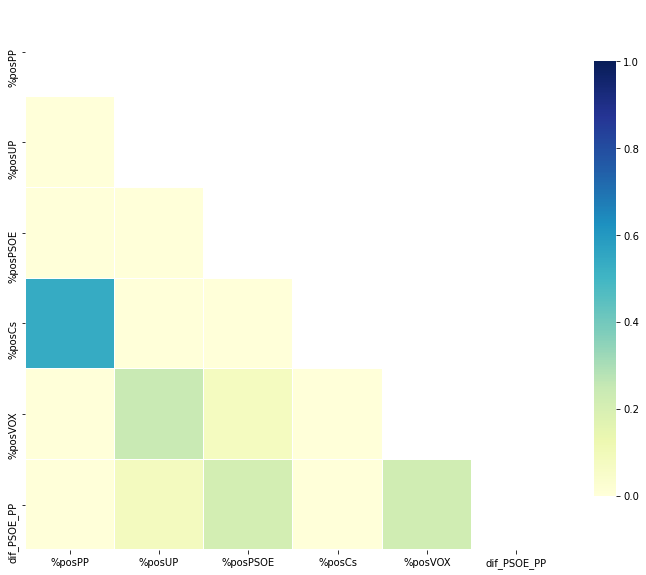

In [44]:
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(df_train).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

Ahora simplemente definimos el vector 'y' y la matriz X del dataset de train.

In [45]:
y_train = df_train['dif_PSOE_PP'].values

In [46]:
X_train = df_train.drop(columns = ['dif_PSOE_PP']).values

In [47]:
X_train

array([[1.45985401, 4.5620438 , 4.01459854, 1.09489051, 6.75182482],
       [2.47026532, 2.74473925, 5.4894785 , 1.46386093, 5.85544373],
       [2.04978038, 4.83162518, 3.07467057, 0.9760859 , 6.63738409],
       [3.19732034, 3.16686967, 4.29354446, 2.13154689, 5.69427527],
       [2.0001613 , 3.33091378, 4.20195177, 1.45979514, 7.64577789],
       [2.22450376, 3.25119781, 3.678987  , 1.69404517, 7.95687885],
       [3.08194344, 2.97316896, 3.40826686, 1.74039159, 6.4902103 ],
       [2.69058296, 2.69058296, 2.91479821, 3.3632287 , 3.58744395],
       [3.41662417, 2.54971953, 3.67159612, 1.78480367, 7.0882203 ],
       [2.58945781, 3.30176821, 3.30176821, 2.49727646, 7.15662449],
       [2.84611674, 3.13555234, 3.76266281, 2.07428847, 6.41582248],
       [2.37012987, 3.66883117, 3.50108225, 1.77489177, 6.87770563],
       [2.21928666, 3.35535007, 4.04227213, 1.13606341, 7.10700132],
       [1.93444385, 3.86888769, 4.35249866, 1.28962923, 6.0720043 ]])

Ahora vamos con el dataset de test. Lo cierto es que no hemos hecho ninguna transformación al de train, así que a éste tampoco. Definimos 'y' y la matriz X de test.

In [48]:
df_test = pd.read_csv('test_twitter.csv')

In [49]:
df_test

,%posPP,%posUP,%posPSOE,%posCs,%posVOX,dif_PSOE_PP
0,2.135417,3.854167,4.114583,0.989583,6.770833,15.049209
1,8.333333,2.777778,7.638889,1.388889,4.166667,-3.225901
2,2.150538,2.822581,3.091398,1.612903,7.258065,3.455133
3,0.943396,1.886792,2.830189,0.943396,8.490566,14.717542
4,1.121705,3.982053,3.309030,1.738643,7.795850,12.663850


In [50]:
y_test = df_test['dif_PSOE_PP'].values

In [51]:
X_test = df_test.drop(columns = ['dif_PSOE_PP']).values

Aplicamos por fin un modelo simple de regresión lineal, para lo cual cargamos las librerías necesarias.

In [52]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

Instanciamos el modelo...

In [53]:
regresion_tweets = linear_model.LinearRegression()

...hacemos el fit...

In [54]:
regresion_tweets.fit(X_train, y_train)

LinearRegression()

...calculamos las predicciones para el test...

In [55]:
regresion_tweets_pred = regresion_tweets.predict(X_test)

In [56]:
regresion_tweets_pred

array([ 7.3410872 ,  1.31710127,  7.91377132,  8.5317814 , 13.12412005])

Y hallamos las métricas del MSE y el R2. no son maravillosas pero son mejor de lo que esperábamos, sobre todo dada la literatura. 

Pero sí que llegamos a una conclusión: la diferencia de voto entre PP y PSOE en las elecciones de abril de 2019 NO se explica por la positividad de los tweets previos a estos comicios.

In [57]:
print('Coefficients: \n', regresion_tweets.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, regresion_tweets_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, regresion_tweets_pred))


Coefficients: 
 [-1.99475815  0.50297586  3.10953812  5.07189012  2.34372093]
Mean squared error: 27.68
Coefficient of determination: 0.47


## Correlación porcentaje de Vox y positividad de tweets

No nos demos por vencidos. Podemos intentar ver si la positividad de los tweets puede explicar el porcentaje obtenido por Vox en las elecciones.

In [58]:
votos_tweets

,CCAA,%PP,%PSOE,%Cs,%UP,%VOX,%posPP,%posUP,%posPSOE,%posCs,%posVOX,dif_PSOE_PP
0,baleares,16.668101,26.080464,17.247267,17.642301,11.173955,3.081943,2.973169,3.408267,1.740392,6.490210,9.412363
1,andalucia,16.964709,33.782213,17.471376,14.070037,13.201167,2.000161,3.330914,4.201952,1.459795,7.645778,16.817504
2,aragon,18.726495,31.390344,20.311623,13.413534,12.073885,1.121705,3.982053,3.309030,1.738643,7.795850,12.663850
3,asturias,17.716904,32.766113,16.527142,16.967276,11.369969,2.135417,3.854167,4.114583,0.989583,6.770833,15.049209
4,extremadura,21.050728,37.457054,17.669229,9.339235,10.598385,2.470265,2.744739,5.489478,1.463861,5.855444,16.406326
5,canarias,15.346882,27.515326,14.488856,15.530671,6.473119,1.934444,3.868888,4.352499,1.289629,6.072004,12.168444
6,cantabria,21.474449,24.929582,14.977414,10.114192,11.060027,2.150538,2.822581,3.091398,1.612903,7.258065,3.455133
7,castillaleon,25.708589,29.382885,18.652369,10.252079,12.132890,3.197320,3.166870,4.293544,2.131547,5.694275,3.674295
8,castillalamancha,22.373185,31.924142,17.231675,10.007092,15.077684,2.846117,3.135552,3.762663,2.074288,6.415822,9.550956
9,catalunya,4.822832,23.109454,11.500276,14.781510,3.571182,2.589458,3.301768,3.301768,2.497276,7.156624,18.286623


Ahora la columna del porcentaje de voto de Vox es directamente nuestra variable objetivo. El resto de columnas son las positividades de los tweets.

In [59]:
votos_tweets.columns

Index(['CCAA', '%PP', '%PSOE', '%Cs', '%UP', '%VOX', '%posPP', '%posUP',
       '%posPSOE', '%posCs', '%posVOX', 'dif_PSOE_PP'],
      dtype='object')

In [60]:
votos_tweets_model_vox = votos_tweets[[ '%posPP', '%posUP',
       '%posPSOE', '%posCs', '%posVOX', '%VOX']]

In [61]:
votos_tweets_model_vox 

,%posPP,%posUP,%posPSOE,%posCs,%posVOX,%VOX
0,3.081943,2.973169,3.408267,1.740392,6.490210,11.173955
1,2.000161,3.330914,4.201952,1.459795,7.645778,13.201167
2,1.121705,3.982053,3.309030,1.738643,7.795850,12.073885
3,2.135417,3.854167,4.114583,0.989583,6.770833,11.369969
4,2.470265,2.744739,5.489478,1.463861,5.855444,10.598385
5,1.934444,3.868888,4.352499,1.289629,6.072004,6.473119
6,2.150538,2.822581,3.091398,1.612903,7.258065,11.060027
7,3.197320,3.166870,4.293544,2.131547,5.694275,12.132890
8,2.846117,3.135552,3.762663,2.074288,6.415822,15.077684
9,2.589458,3.301768,3.301768,2.497276,7.156624,3.571182


Y hacemos el split entre train y test, quedándonos de nuevo con el train.

In [63]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(votos_tweets_model_vox, test_size=0.25, shuffle=True, random_state=1)

print(f'Dimensiones del dataset de training: {train.shape}')
print(f'Dimensiones del dataset de test: {test.shape}')

# Guardamos
train.to_csv('train_twitter_vox.csv', index=False)
test.to_csv('test_twitter_vox.csv', index=False)

# A partir de este momento cargamos el dataset de train y trabajamos ÚNICAMENTE con él. 

df_train = pd.read_csv('train_twitter_vox.csv')

Dimensiones del dataset de training: (14, 6)
Dimensiones del dataset de test: (5, 6)


Definimos el vector 'y' y la matrix X del dataset de train.

In [64]:
y_train = df_train['%VOX'].values
X_train = df_train.drop(columns = ['%VOX']).values

Intentamos ver las correlaciones entre columnas. A primera vista sí parece haber relaciones mayores con nuestra variable objetivo, pero cuando imprimimos los números, no son nada del otro jueves.

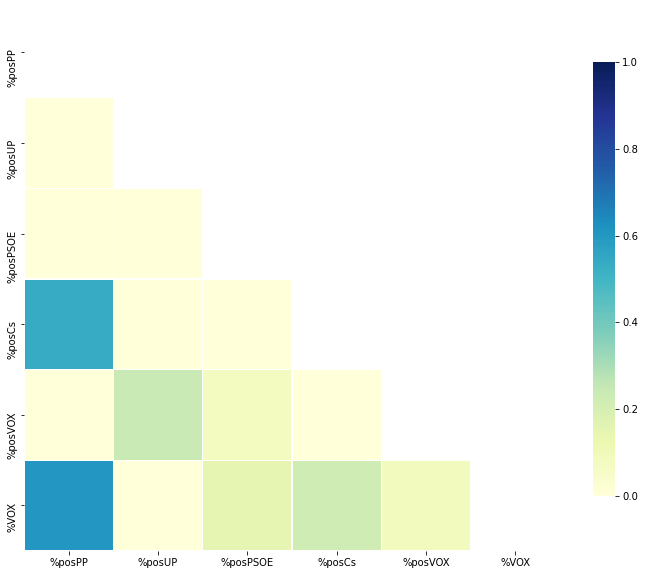

In [65]:
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(df_train).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

In [66]:
corr = np.abs(df_train).corr()

In [67]:
corr

,%posPP,%posUP,%posPSOE,%posCs,%posVOX,%VOX
%posPP,1.000000,-0.743672,-0.145427,0.538466,-0.240762,0.605402
%posUP,-0.743672,1.000000,-0.158187,-0.598088,0.242924,-0.649048
%posPSOE,-0.145427,-0.158187,1.000000,-0.413330,0.080638,0.149151
%posCs,0.538466,-0.598088,-0.413330,1.000000,-0.596831,0.229268
%posVOX,-0.240762,0.242924,0.080638,-0.596831,1.000000,0.085949
%VOX,0.605402,-0.649048,0.149151,0.229268,0.085949,1.000000


Ahora cargamos el dataset de test, y simplemente definimos sus vectores y matrices para aplicar luego en el modelo.

In [68]:
df_test = pd.read_csv('test_twitter_vox.csv')

In [69]:
y_test = df_test['%VOX'].values
X_test = df_test.drop(columns = ['%VOX']).values

Instanciamos y entrenamos un nuevo modelo, a ver qué sale...

In [70]:
regresion_tweets_vox = linear_model.LinearRegression()
regresion_tweets_vox.fit(X_train, y_train)

LinearRegression()

...hacemos la predicción...

In [71]:
regresion_tweets_pred_vox = regresion_tweets_vox.predict(X_test)

... y vemos lo buena que es. Vaya, es nefasta.

El voto a Vox no puede ser explicado por los tweets faborables a tal o cual partido.

In [72]:
print('Coefficients: \n', regresion_tweets_vox.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, regresion_tweets_pred_vox))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, regresion_tweets_pred_vox))

Coefficients: 
 [ 3.25286469 -3.31566376  0.61393996 -0.50426382  1.08469314]
Mean squared error: 80.42
Coefficient of determination: -2.44


Hacemos un último intento. Vimos que la correlación con los votos a Vox estaba algo más correlacionado con las positidades de los tweets a PP y PSOE. Tomamos pues estas dos columnas.

Modificamos las matrices X de train y test.

In [73]:
X_train = df_train[['%posPP', '%posPSOE']].values

In [74]:
X_test = df_test[['%posPP', '%posPSOE']].values

In [75]:
X_train.shape

(14, 2)

In [76]:
X_test.shape

(5, 2)

Instanciamos el modelo y hacemos el entrenamiento.

In [77]:
regresion_tweets_vox = linear_model.LinearRegression()
regresion_tweets_vox.fit(X_train, y_train)

LinearRegression()

Calculamos las predicciones...

In [78]:
regresion_tweets_pred_vox = regresion_tweets_vox.predict(X_test)

... que resultan ser otro desastre. No parece haber relación pues entre positividad de los tweets y el voto en unas elecciones.

In [79]:
print('Coefficients: \n', regresion_tweets_vox.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, regresion_tweets_pred_vox))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, regresion_tweets_pred_vox))

Coefficients: 
 [5.63323892 1.78327905]
Mean squared error: 358.94
Coefficient of determination: -14.38
